# SC4002 / CE4045 / CZ4045 NLP — Assignment — Part 3.2: CNN

This notebook replaces the simple RNN from Part 2 with a **Convolutional Neural Network (CNN)** as required in Part 3.2, and logs:
- Training loss per epoch
- Validation and training accuracy per epoch 
- Final test accuracy

## Setup

In [1]:
from torchtext import data, datasets
import torch
import spacy
import random
import numpy as np

def set_seed(seed = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(888)

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
from itertools import product
import pandas as pd
from collections import Counter, defaultdict

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Prepared TREC Dataset

We reuse the same data pipeline introducted in 3.1 to load the TREC dataset that was prepared in Part 1.  

In [2]:
LOAD_PREPARED = True  
if LOAD_PREPARED:
    bundle = torch.load("trec_artifacts.pt", map_location="cpu")


    TEXT = data.Field(**bundle["text_field_kwargs"])
    LABEL = data.LabelField(**bundle["label_field_kwargs"])
    fields = [("text", TEXT), ("label", LABEL)]

    def rebuild(dataset_blob):
        examples = [
            data.Example.fromlist([item["tokens"], item["label"]], fields)
            for item in dataset_blob
        ]
        return data.Dataset(examples, fields)

    train_data = rebuild(bundle["train_examples"])
    valid_data = rebuild(bundle["valid_examples"])
    test_data  = rebuild(bundle["test_examples"])

    for ds in (train_data, valid_data, test_data):
        ds.sort_key = lambda ex: len(ex.text)

    TEXT.build_vocab([])
    TEXT.vocab.itos = bundle["text_vocab_itos"]
    unk_token = TEXT.unk_token
    if unk_token not in TEXT.vocab.itos:
        raise ValueError("UNK token missing from serialized vocabulary.")
    unk_index = TEXT.vocab.itos.index(unk_token)
    TEXT.vocab.stoi = defaultdict(lambda: unk_index,
                                  {tok: i for i, tok in enumerate(TEXT.vocab.itos)})
    TEXT.vocab.vectors = bundle["text_vocab_vectors"]

    LABEL.build_vocab([])
    LABEL.vocab.itos = bundle["label_vocab_itos"]
    LABEL.vocab.stoi = {tok: i for i, tok in enumerate(LABEL.vocab.itos)}



    pretrained_embeddings = TEXT.vocab.vectors

    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size=bundle["batch_size"],
        sort_within_batch=True,
        device=DEVICE,
    )
    print("Artifacts loaded.")

Artifacts loaded.


In [3]:
# Build from scratch via torchtext 0.4.0 ---

USE_TORCHTEXT_PIPELINE = False  

if USE_TORCHTEXT_PIPELINE:
    from torchtext import data, datasets
    # tokenizer setup
    TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm', include_lengths=True)
    LABEL = data.LabelField()
    train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

    # split train/valid (80/20)
    train_data, valid_data = train_data.split(split_ratio=0.8, random_state=random.seed(42))

    # Build vocab using your chosen pretrained vectors (Word2Vec or GloVe). Example with GloVe 100d:
    # WARNING: This may attempt a download if not present locally.
    vectors_name, vectors_dim = 'glove.6B.100d', 100
    TEXT.build_vocab(train_data, vectors=vectors_name, max_size=25000)
    LABEL.build_vocab(train_data)

    # Create iterators
    BATCH_SIZE = 64
    device = DEVICE
    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size=BATCH_SIZE,
        sort_within_batch=True,
        device=device
    )

    # Extract pretrained embeddings from vocab
    pretrained_embeddings = TEXT.vocab.vectors  # FloatTensor [vocab_size, emb_dim]
else:
    print("Skipping torchtext pipeline. Make sure you load your artifacts in Option A instead.")

Skipping torchtext pipeline. Make sure you load your artifacts in Option A instead.


## Question 3b.
Plot the training loss curve and validation accuracy curve of CNN. Report its accuracy score on the test set (Part 3.2)

This section implements a CNN to produce sentence representations and perform topic classification. 

## CNN Model

CNN is a feedforward neural network that learns features through kernel optimisation. CNNs were originally developed for tasks relating to image classification. However, it has been used in the context of NLP as they can detect local patterns of n-grams depending on the filter size. Unlike RNNs or LSTMs, CNNs do not requiring sequential processing.

CNN processes text by sliding filters across the embedded word sequences to detect local n-gram patterns. This allows for CNN to be effective for short text classification tasks.

Similar to 3.1, hyperparameter tuning (e.g. number of filters, filter size, dropout) is left out to assess the base CNN model.


### Approach

In this CNN Model, each input token is first mapped to a dense vector using a trainable embedding layer with pre-trained GloVe embeddings. 1-D convolutional layers with different filter sizes is applied, allowing the model to learn features corresponding to the 3-grams, 4-grams and 5-grams. After each convolution, the ReLu activation function introduces non-linearity for each N-gram layer and max pooling is done to select the most relevant features across the entire input sequence, creating a fixed-size, position-invariant representation. 


In [4]:
# Define the CNN Classifier for sentence representation and topic classification
# use multiple filter sizes to capture different n-gram patterns, then apply max pooling and dropout
class ClassifierCNN(nn.Module):
    def __init__(self, embedding_matrix, num_filters,num_classes, filter_sizes=[3, 4, 5], dropout=0.0):
        super(ClassifierCNN, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
    
    # UPDATED: to add padding to Conv1D layers so that short sentences can be processed
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=fs,
                padding=fs // 2   # SAME padding trick
            )
            for fs in filter_sizes
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes) 

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        # Conv1d: input of shape (batch_size, embedding_dim, seq_len)
        embedded = embedded.permute(0, 2, 1) 
        
        # convolutions and max pooling
        conv_outputs = []
        for conv in self.convs:
            conv_out = torch.relu(conv(embedded))  # (batch_size, num_filters, conv_seq_len)
            pooled = torch.max_pool1d(conv_out, kernel_size=conv_out.size(2))  # (batch_size, num_filters, 1)
            conv_outputs.append(pooled.squeeze(2)) 
        
        # concatenate all conv outputs
        concatenated = torch.cat(conv_outputs, dim=1)
        
        dropped = self.dropout(concatenated)
        out = self.fc(dropped)
        return out



In [5]:
import torch
from torch.nn.utils import clip_grad_norm_

def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

def _extract_batch_cnn(batch, device):
    if isinstance(batch.text, (tuple, list)):
        text = batch.text[0]
    else:
        text = batch.text

    labels = batch.label

    # Convert [seq_len, batch] -> [batch, seq_len] if needed
    if text.dim() == 2 and text.size(0) != labels.size(0):
        text = text.transpose(0, 1)

    return text.to(device), labels.to(device)

def train_loop_cnn(model, iterator, optimizer, criterion, device, grad_clip=None, max_norm=1.0):
    model.train()
    total_loss, total_correct, total_examples, total_batches = 0.0, 0, 0, 0

    for batch in iterator:
        text, labels = _extract_batch_cnn(batch, device)

        optimizer.zero_grad()
        logits = model(text)       
        loss = criterion(logits, labels)
        loss.backward()

        if grad_clip is not None:
            clip_grad_norm_(model.parameters(), max_norm=max_norm)

        optimizer.step()

        total_loss    += loss.item()
        total_correct += (logits.argmax(1) == labels).sum().item()
        total_examples += labels.size(0)
        total_batches  += 1

    avg_loss = total_loss / max(total_batches, 1)
    avg_acc  = total_correct / max(total_examples, 1)
    return avg_loss, avg_acc

def eval_loop_cnn(model, iterator, criterion, device):
    model.eval()
    total_loss, total_correct, total_examples, total_batches = 0.0, 0, 0, 0
    with torch.no_grad():
        for batch in iterator:
            text, labels = _extract_batch_cnn(batch, device)
            logits = model(text)
            loss = criterion(logits, labels)

            total_loss    += loss.item()
            total_correct += (logits.argmax(1) == labels).sum().item()
            total_examples += labels.size(0)
            total_batches  += 1

    avg_loss = total_loss / max(total_batches, 1)
    avg_acc  = total_correct / max(total_examples, 1)
    return avg_loss, avg_acc

def test_loop_cnn(model, iterator, device):
    model.eval()
    total_correct, total_examples = 0, 0
    with torch.no_grad():
        for batch in iterator:
            text, labels = _extract_batch_cnn(batch, device)
            logits = model(text)
            total_correct += (logits.argmax(1) == labels).sum().item()
            total_examples += labels.size(0)
    return total_correct / max(total_examples, 1)

def topic_eval_loop_cnn(model, iterator, label_vocab, device):
    model.eval()
    n = len(label_vocab.itos)
    correct = [0] * n
    total   = [0] * n
    with torch.no_grad():
        for batch in iterator:
            text, labels = _extract_batch_cnn(batch, device)
            logits = model(text)
            preds = torch.argmax(logits, dim=1)
            for p, y in zip(preds.tolist(), labels.tolist()):
                total[y]   += 1
                correct[y] += int(p == y)

    per_topic = {}
    for idx, lab in enumerate(label_vocab.itos):
        per_topic[lab] = float('nan') if total[idx] == 0 else correct[idx] / total[idx]
    return per_topic


## CNN Model Training: 

In the training of the CNN model, we used a similar training strategy used in Part 2. Cross entropy loss is used as the loss function and Adam optimiser with learning rate of 0.0001 is used. Early stopping is implemented with patience = 3 is implemented in the training process to prevent overfitting. 

Since hyperparameters tuning is left out, we have taken the optimal hyperparameters found in Part 2(a): 

- Learning rate: 0.0001
- Optimiser: Adam
- Batch size = 64
- Dropout = 0.4
- Pooling = max

In [6]:
vocab_size, emb_dim = pretrained_embeddings.shape
print("Vocab size:", vocab_size, "Embedding dim:", emb_dim)


Vocab size: 8093 Embedding dim: 300


In [7]:
# --- HYPERPARAMETERS ---
EMB_DIM = 300
NUM_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
DROPOUT = 0.4
NUM_CLASSES = len(LABEL.vocab)
BATCH_SIZE = 64 # From Part 2
EPOCHS = 50
LR = 0.0001 # From Part 2

# --- Derive sizes from loaded pipeline ---
if 'TEXT' in globals() and 'LABEL' in globals():
    vocab_size = len(TEXT.vocab)
    num_classes = len(LABEL.vocab)
    print(f"vocab_size={vocab_size}, num_classes={num_classes}")
else:
    raise RuntimeError("TEXT/LABEL not available. Please enable Option A (load your artifacts) or Option B (torchtext pipeline).")

# --- Build model ---
emb_matrix = None
if 'pretrained_embeddings' in globals() and pretrained_embeddings is not None:
    # Ensure shape [vocab_size, EMB_DIM]
    if pretrained_embeddings.size(1) != EMB_DIM:
        raise ValueError(f"Embedding dim mismatch: got {pretrained_embeddings.size(1)} vs EMB_DIM={EMB_DIM}")
    emb_matrix = pretrained_embeddings

cnn_model = ClassifierCNN(
    embedding_matrix=TEXT.vocab.vectors,
    num_filters=NUM_FILTERS,
    filter_sizes=FILTER_SIZES,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES
)

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

vocab_size=8093, num_classes=6


/var/folders/bw/_dd4c0bn1ws10nbrwf6ls6hc0000gn/T/ipykernel_82035/1351471854.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)


In [8]:
print(cnn_model)

ClassifierCNN(
  (embedding): Embedding(8093, 300)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,), padding=(2,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=300, out_features=6, bias=True)
)


In [9]:
def train_cnn_with_early_stopping(model, train_iter, valid_iter, optimizer, criterion, device, 
                                    epochs=50, patience=3, save_path="cnn_best.pt", grad_clip=None, max_norm=1.0):
    best_val_acc = -1.0
    wait = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    epochs_ran = 0

    for epoch in range(1, epochs + 1):
        # ---- Train ----
        tr_loss, tr_acc = train_loop_cnn(
            model, train_iter, optimizer, criterion,
            device, grad_clip=grad_clip, max_norm=max_norm
        )

        # ---- Validate ----
        val_loss, val_acc = eval_loop_cnn(
            model, valid_iter, criterion, device
        )

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch:02d} | "
            f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
        )

        # ---- Early Stopping ----
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            wait = 0
            torch.save(model.state_dict(), save_path)
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered!")
                epochs_ran = epoch
                break

        epochs_ran = epoch

    return history, (best_val_acc, epochs_ran)


In [10]:
history, (best_val_acc, epochs_ran) = train_cnn_with_early_stopping(
    cnn_model,
    train_iter,
    valid_iter,
    optimizer,
    criterion,
    device=DEVICE,
    epochs=EPOCHS,
    patience=3,
    save_path="cnn_best.pt",
    grad_clip=1.0
)

print("Best Val Acc:", best_val_acc, "| Epochs:", epochs_ran)

Epoch 01 | Train Loss: 1.6265 | Train Acc: 0.3189 | Val Loss: 1.5583 | Val Acc: 0.4229
Epoch 02 | Train Loss: 1.4534 | Train Acc: 0.5016 | Val Loss: 1.4587 | Val Acc: 0.5092
Epoch 03 | Train Loss: 1.3242 | Train Acc: 0.5624 | Val Loss: 1.3818 | Val Acc: 0.5202
Epoch 04 | Train Loss: 1.2050 | Train Acc: 0.6165 | Val Loss: 1.3009 | Val Acc: 0.5450
Epoch 05 | Train Loss: 1.0915 | Train Acc: 0.6600 | Val Loss: 1.1951 | Val Acc: 0.6064
Epoch 06 | Train Loss: 0.9855 | Train Acc: 0.6939 | Val Loss: 1.1210 | Val Acc: 0.6284
Epoch 07 | Train Loss: 0.8909 | Train Acc: 0.7221 | Val Loss: 1.0426 | Val Acc: 0.6514
Epoch 08 | Train Loss: 0.7924 | Train Acc: 0.7634 | Val Loss: 0.9915 | Val Acc: 0.6780
Epoch 09 | Train Loss: 0.7142 | Train Acc: 0.7884 | Val Loss: 0.9106 | Val Acc: 0.6936
Epoch 10 | Train Loss: 0.6409 | Train Acc: 0.8132 | Val Loss: 0.8425 | Val Acc: 0.7229
Epoch 11 | Train Loss: 0.5659 | Train Acc: 0.8457 | Val Loss: 0.7977 | Val Acc: 0.7431
Epoch 12 | Train Loss: 0.5105 | Train Acc: 

In [11]:
cnn_model.load_state_dict(torch.load("cnn_best.pt", map_location=DEVICE))
te_loss, te_acc = eval_loop_cnn(cnn_model, test_iter, criterion, device=DEVICE)
print(f"Test Loss: {te_loss:.4f} | Test Acc: {te_acc:.4f}")

topic_acc = topic_eval_loop_cnn(cnn_model, test_iter, LABEL.vocab, device=DEVICE)
print("Topic-wise accuracy:")
for k, v in topic_acc.items():
    print(f"  {k}: {v:.4f}")

Test Loss: 0.2635 | Test Acc: 0.9220
Topic-wise accuracy:
  HUM: 0.9538
  ENTY: 0.7872
  DESC: 0.9855
  NUM: 0.9469
  LOC: 0.9259
  ABBR: 0.7778


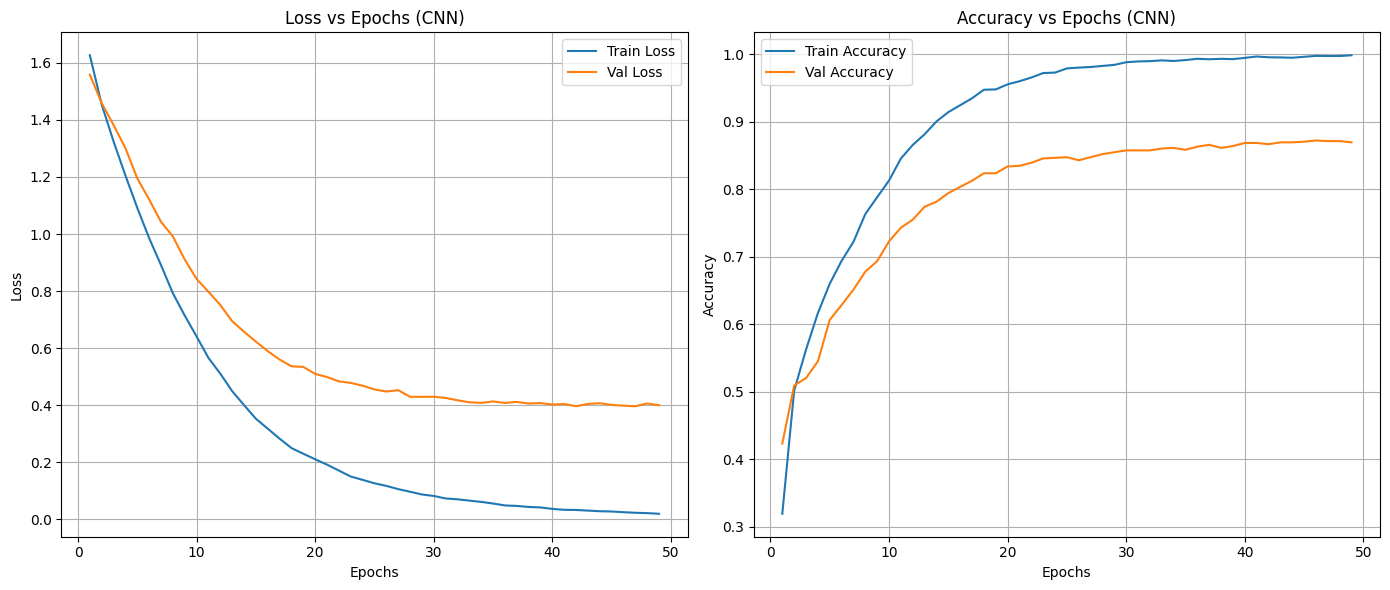

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14, 6))

# ---- Left: Loss vs Epochs ----
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (CNN)")
plt.grid(True)
plt.legend()

# ---- Right: Accuracy vs Epochs ----
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs (CNN)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


The base CNN model without hyperameters tuning achieved 0.9220 test accuracy and test loss of 0.2635. During training, early stopping was triggered at epoch 34, preventing overfitting on the training dataset by halting training once validation accuracy plateaued. The best validation accuracy achieved was 0.8697. The training curves show a steady decline in both training and validation loss and increase in accuracies across epochs.